Training the Logistic regression model
Testing the model


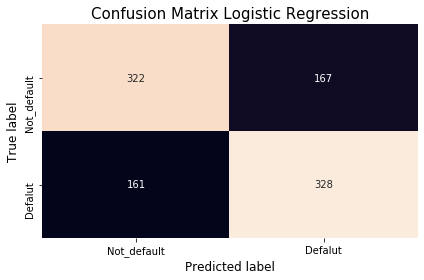

Accuracy_score: 0.66
Precision: 0.66
Recall: 0.67
F1_Score: 0.66

ROC Curve


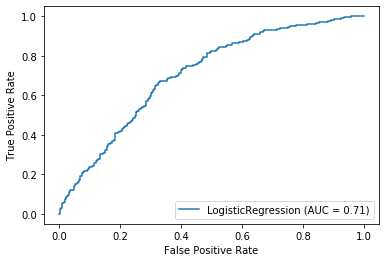

In [3]:
!pip install imblearn
!pip install scorecardpy
!pip install scikit-learn

print("Loading libraries....")
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from sklearn.linear_model import LogisticRegression
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
import scorecardpy as sc
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, f1_score,roc_auc_score,plot_roc_curve

def plot_confusion_matrix(estimator,X,y_true, classifier_name):
    y_pred=estimator.predict(X)
    
    #y_pred = estimator.predict_proba(X)[:, 1] > .55
    
    cm=confusion_matrix(y_true=y_true,y_pred=y_pred)
    data=pd.DataFrame(cm, index=['Not_default', "Defalut"], columns=['Not_default', "Defalut"])
    sns.heatmap(data,annot=True,fmt='g',cbar=False)
    plt.ylabel("True label",size=12)
    plt.xlabel("Predicted label",size=12)
    plt.title("Confusion Matrix "+ classifier_name , size=15)
    plt.tight_layout()
    
    plot_roc_curve(estimator=estimator,X=X,y=y_true)
    plt.show()
    print("Accuracy_score:",accuracy_score(y_true=y_true,y_pred=y_pred)//0.01/100)
    print("Precision:",precision_score(y_true=y_true,y_pred=y_pred)//0.01/100)
    print("Recall:",recall_score(y_true=y_true,y_pred=y_pred)//0.01/100)
    print("F1_Score:",f1_score(y_true=y_true,y_pred=y_pred)//0.01/100)
    print()
    print("ROC Curve")


print("Reading the datasets....")
df=pd.read_csv("train_v2.csv")
print("Converting the labels....")
df["loss"]=df["loss"].apply(lambda x:x if x==0 else 1)
df.drop(["id"], axis=1, inplace=True)

print("Undersampling the data....")
rus=RandomUnderSampler(random_state=42)
X, y=rus.fit_resample(df, df["loss"])

print("Filling the null value with zeros....")
X=X.fillna(0)
print("Selecting the numeric columns....")
df_neumeric=X.select_dtypes(exclude=["object"])

print("Removing the duplicates columns....")
df_neumeric=df_neumeric.T.drop_duplicates(keep='first').T
# filter variable via missing rate, iv, identical value rate
print("filter variable via missing rate, iv, identical value rate. Please wait, this step will take time..")
df_neumeric= sc.var_filter(df_neumeric, y="loss")

#dt_s_=dt_s.select_dtypes(exclude=["object"])
# breaking dt into train and test
print("breaking data into train and test....")
train, test = sc.split_df(df_neumeric, 'loss',ratio=0.95).values()

# woe binning ------
print("weight of evidence binning")
bins = sc.woebin(df_neumeric, y="loss")

# converting train and test into woe values
print("converting train and test into woe values....")
train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)



#splitting the data in training and test test
print("splitting the data in training and test test")
y_train = train_woe.loc[:,'loss']
X_train = train_woe.loc[:,train_woe.columns != 'loss']
y_test = test_woe.loc[:,'loss']
X_test = test_woe.loc[:,train_woe.columns != 'loss']

# logistic regression ------
print("Training the Logistic regression model")

logistic = LogisticRegression(C=0.9, n_jobs=-1)
logistic.fit(X_train, y_train)

print("Testing the model")

plot_confusion_matrix(estimator=logistic,X=X_test,y_true=y_test, classifier_name="Logistic Regression")